In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

print('modules loaded')


modules loaded


In [2]:
data_dir = r"D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB_Chest_Radiography_Database/New_folder"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
labels = df['labels']
print(df)


                                              filepaths        labels
0     D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...        Normal
1     D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...        Normal
2     D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...        Normal
3     D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...        Normal
4     D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...        Normal
...                                                 ...           ...
4195  D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...  Tuberculosis
4196  D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...  Tuberculosis
4197  D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...  Tuberculosis
4198  D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...  Tuberculosis
4199  D:/CAPSTONE 400A/final_dataset/Tuberculosis/TB...  Tuberculosis

[4200 rows x 2 columns]


In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 1
k = 2  
NUM_CLASSES = 2


In [4]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)
    return callbacks


def build_model():
    base_model = tf.keras.applications.EfficientNetB3(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  

In [5]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
fold_no = 1
accuracies = []


In [6]:
# Create lists to store history data for each fold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Create a list to store confusion matrices
confusion_matrices = []

for train_index, test_index in skf.split(df['filepaths'], df['labels']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    tr_gen = ImageDataGenerator()
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode='rgb', shuffle=True, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    class_count = len(classes)

    model = build_model()
    callbacks = get_callbacks(f'Xception_fold_{fold_no}')

    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=test_gen,
                        callbacks=callbacks)

    # Store history data
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    ts_length = len(test_df)
    test_batch_size = min(32, ts_length)
    test_steps = ts_length // test_batch_size

    test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Fold {fold_no} - Test Loss: ", test_score[0])
    print(f"Fold {fold_no} - Test Accuracy: ", test_score[1])

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(f"Classification Report for Fold {fold_no}")
    print(classification_report(test_gen.classes, y_pred, target_names=classes))

    # Store confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)
    confusion_matrices.append(cm)

    accuracies.append(test_score[1])
    fold_no += 1

Found 2100 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.
66/66 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9619 
Epoch 1: saving model to model.Xception_fold_1.h5
65/65 [==============================] - 211s 3s/step - loss: 2.2136 - accuracy: 0.8856
Fold 1 - Test Loss:  2.2135703563690186
Fold 1 - Test Accuracy:  0.8855769038200378
66/66 [==============================] - 206s 3s/step
Classification Report for Fold 1
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93      1750
Tuberculosis       1.00      0.27      0.42       350

    accuracy                           0.88      2100
   macro avg       0.94      0.63      0.68      2100
weighted avg       0.89      0.88      0.85      2100

Found 2100 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.
66/66 [=============================

In [7]:
print(f"Average accuracy over {k} folds: {np.mean(accuracies)}")

Average accuracy over 2 folds: 0.9036057591438293


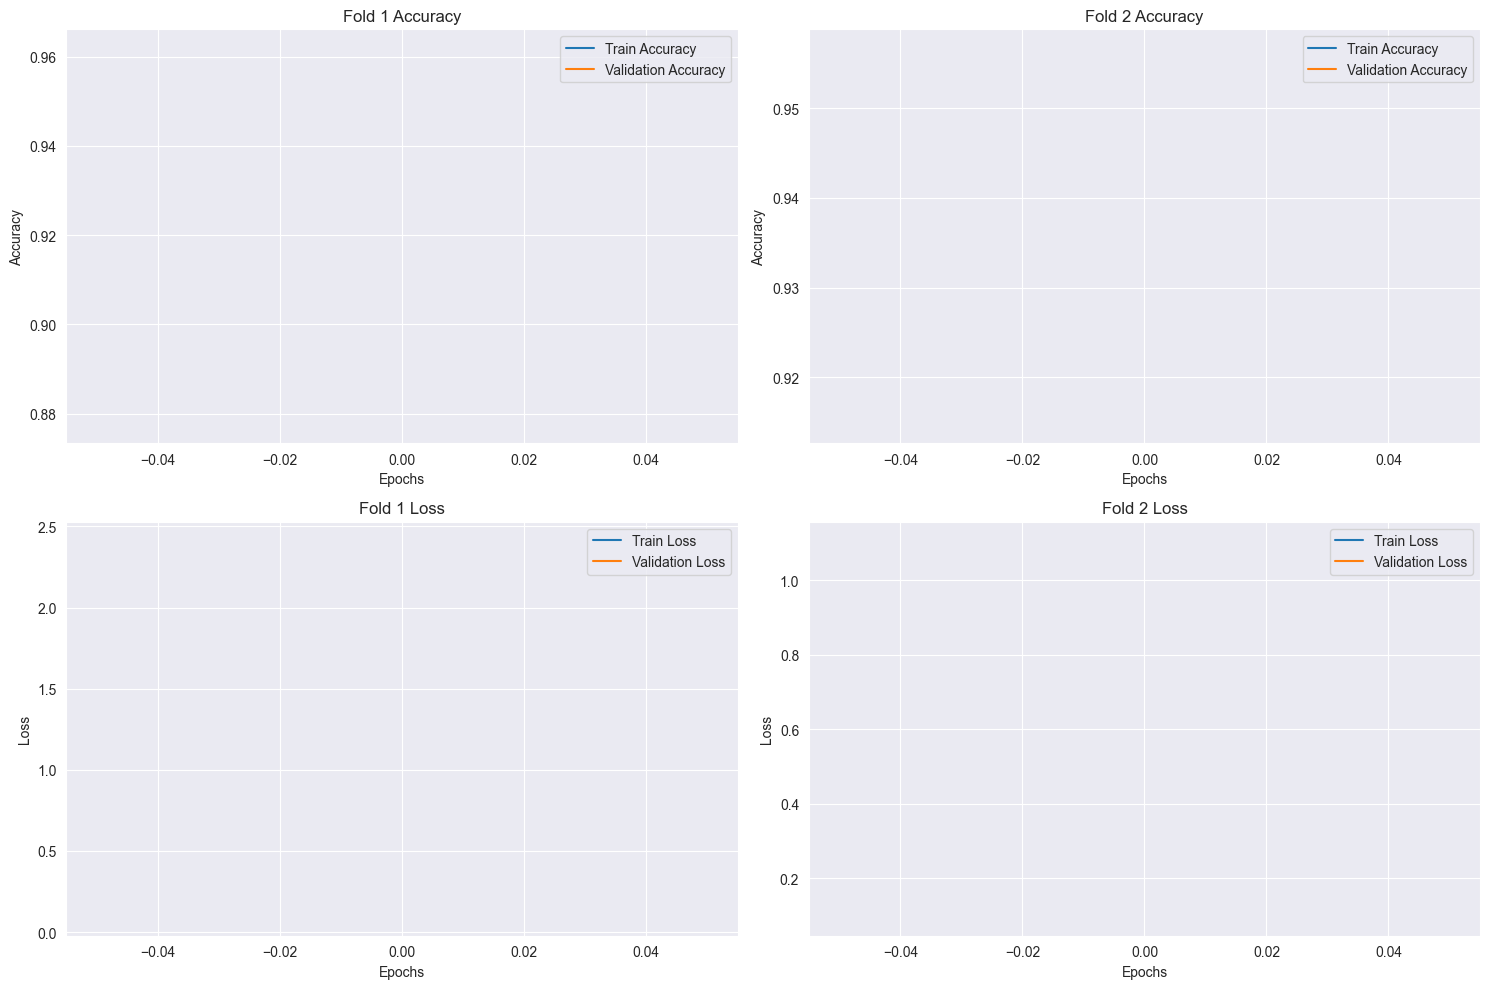

In [10]:
fig, axs = plt.subplots(2, k, figsize=(15, 10))

for i in range(k):
    # Accuracy plot
    axs[0, i].plot(train_accuracies[i], label='Train Accuracy')
    axs[0, i].plot(val_accuracies[i], label='Validation Accuracy')
    axs[0, i].set_title(f'Fold {i+1} Accuracy')
    axs[0, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Accuracy')
    axs[0, i].legend()

    # Loss plot
    axs[1, i].plot(train_losses[i], label='Train Loss')
    axs[1, i].plot(val_losses[i], label='Validation Loss')
    axs[1, i].set_title(f'Fold {i+1} Loss')
    axs[1, i].set_xlabel('Epochs')
    axs[1, i].set_ylabel('Loss')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


Confusion Matrix for Fold 1


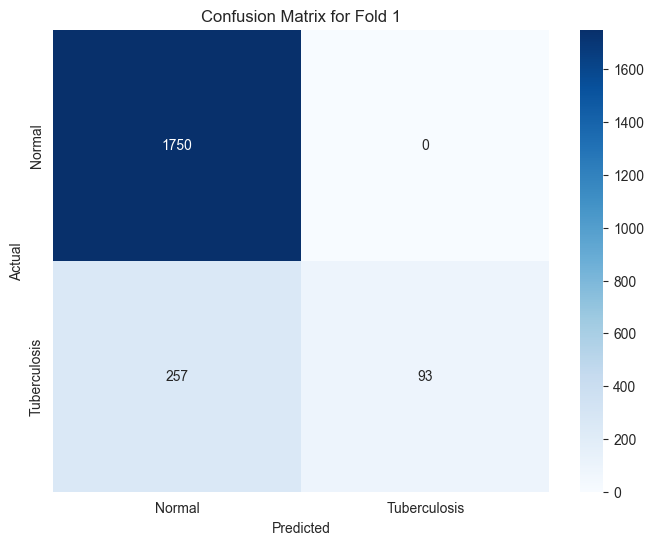

Confusion Matrix for Fold 2


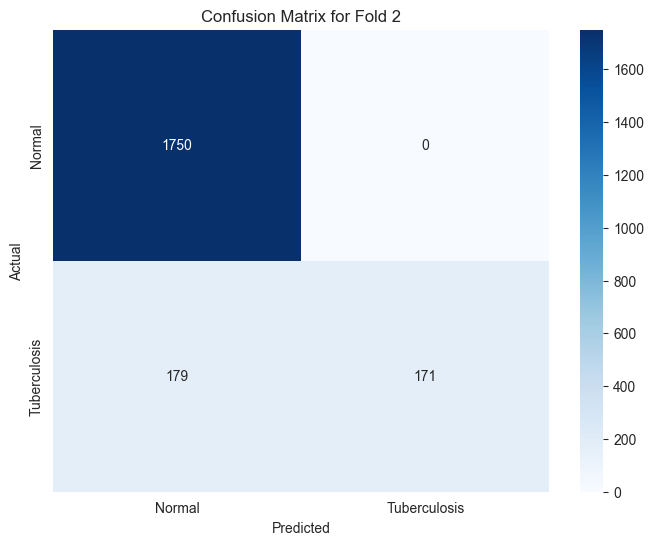

In [9]:
# Plotting confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}")
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
